# Plotting Shapefiles and Rasters & Clipping them

In [1]:
%matplotlib inline
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import rasterio
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask
import os

### I have downloaded a Sentinel 2 image and instead of navigating through the folders I will search to find the TCI file

In [2]:
for root, dir, files in os.walk(r'.\S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349.SAFE'):
    for file in files:
        if file.endswith("TCI_10m.jp2"):
            TCI = (os.path.join(root, file))

print(TCI)

.\S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349.SAFE\GRANULE\L2A_T30UXB_A010316_20190226T111048\IMG_DATA\R10m\T30UXB_20190226T111049_TCI_10m.jp2


##### Next plot it using Rasterio

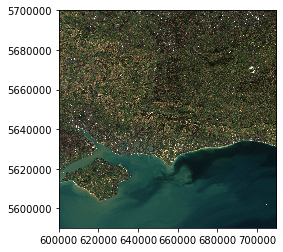

In [3]:
rgb = rasterio.open(TCI, driver='JP2OpenJPEG') #RGB
show(rgb.read(), transform=rgb.transform)

##### Make the image display a little bigger
To do this we need to create a figure and set the figure size - in this case 12,10

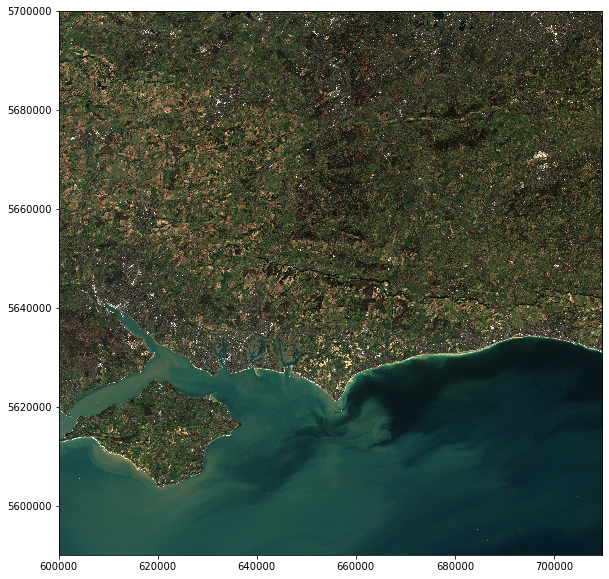

In [4]:
plt.figure(figsize=(12, 10))
show(rgb.read(), transform=rgb.transform)
plt.show()

#### Now open a geojson file (or indeed any vector file) and plot

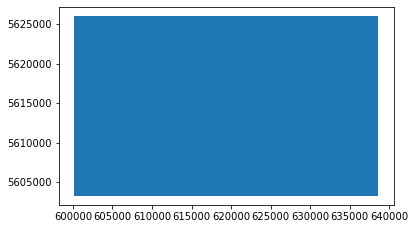

In [5]:
gdf = gpd.read_file('boundary.geojson')
gdf.plot()

### Check the projection
before we plot them together lets check the projection matches

In [6]:
print('vector data projection is:', gdf.crs)
print('raster data projection is:', rgb.crs)

vector data projection is: {'init': 'epsg:32630'}
raster data projection is: EPSG:32630


### In this case they match if they don't you will need to reproject
Now lets plot them together

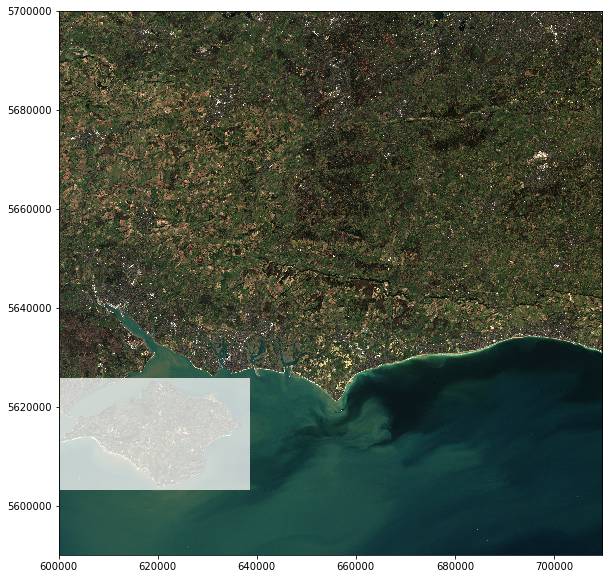

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
show(rgb.read(), transform=rgb.transform, ax=ax)
gdf.plot(ax=ax, color='white', alpha=.75) ## alpha is the transparency setting
plt.show()

### What if we just want to plot the area contained by the boundary.geojson file?
we can use rasterio mask

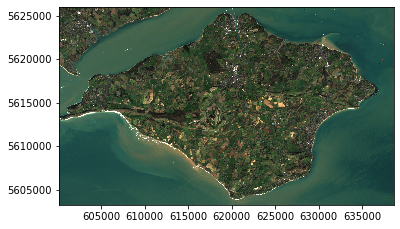

In [8]:
masked, mask_transform = mask(dataset=rgb, shapes=gdf.geometry, crop=True)

show(masked, transform=mask_transform)

### Finally save this clipped file out as a geotiff

In [9]:
## first we need to check the meta data is correct, lets update the orginal one as a new profile that we can assign to the image
profile = rgb.meta
print(profile)

WIDTH = masked.shape[2] ## get the dimensions of the image we are writting out
HEIGHT = masked.shape[1]

profile.update(driver='GTiff', transform=mask_transform, height = HEIGHT, width = WIDTH)
print()
print('updated profile')
print(profile) ## check on the updated profile


{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5700000.0)}

updated profile
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3847, 'height': 2272, 'count': 3, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 600140.0,
       0.0, -10.0, 5626000.0)}


### Write out the file

In [10]:
with rasterio.open('clip.tif', 'w', **profile) as dst:
    dst.write(masked)

### Plot the newly created tif file

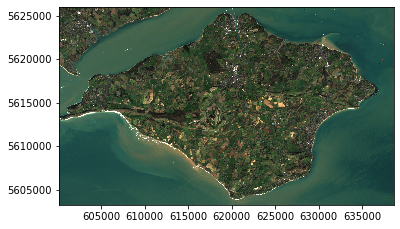

In [11]:
clipped = rasterio.open('clip.tif', driver='GTiff') 
show(clipped.read(), transform=clipped.transform)